In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook
import gc

In [2]:
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [6]:
target = train.target

In [37]:
# https://www.kaggle.com/fayzur/customer-transaction-prediction-strong-baseline
# Thanks fayzur. Nice Parameter 
param = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': -1,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [38]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]
# train_coumns = new_feature

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
#     predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[31]	training's auc: 0.894972	valid_1's auc: 0.891017
CV score: 0.89102 
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[52]	training's auc: 0.895882	valid_1's auc: 0.891711
CV score: 0.89171 
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[31]	training's auc: 0.893538	valid_1's auc: 0.89729
CV score: 0.89729 
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[58]	training's auc: 0.895735	valid_1's auc: 0.889562
CV score: 0.88956 
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[27]	training's auc: 0.895419	valid_1's auc: 0.888019
CV score: 0.88802 
CV score: 0.88881 


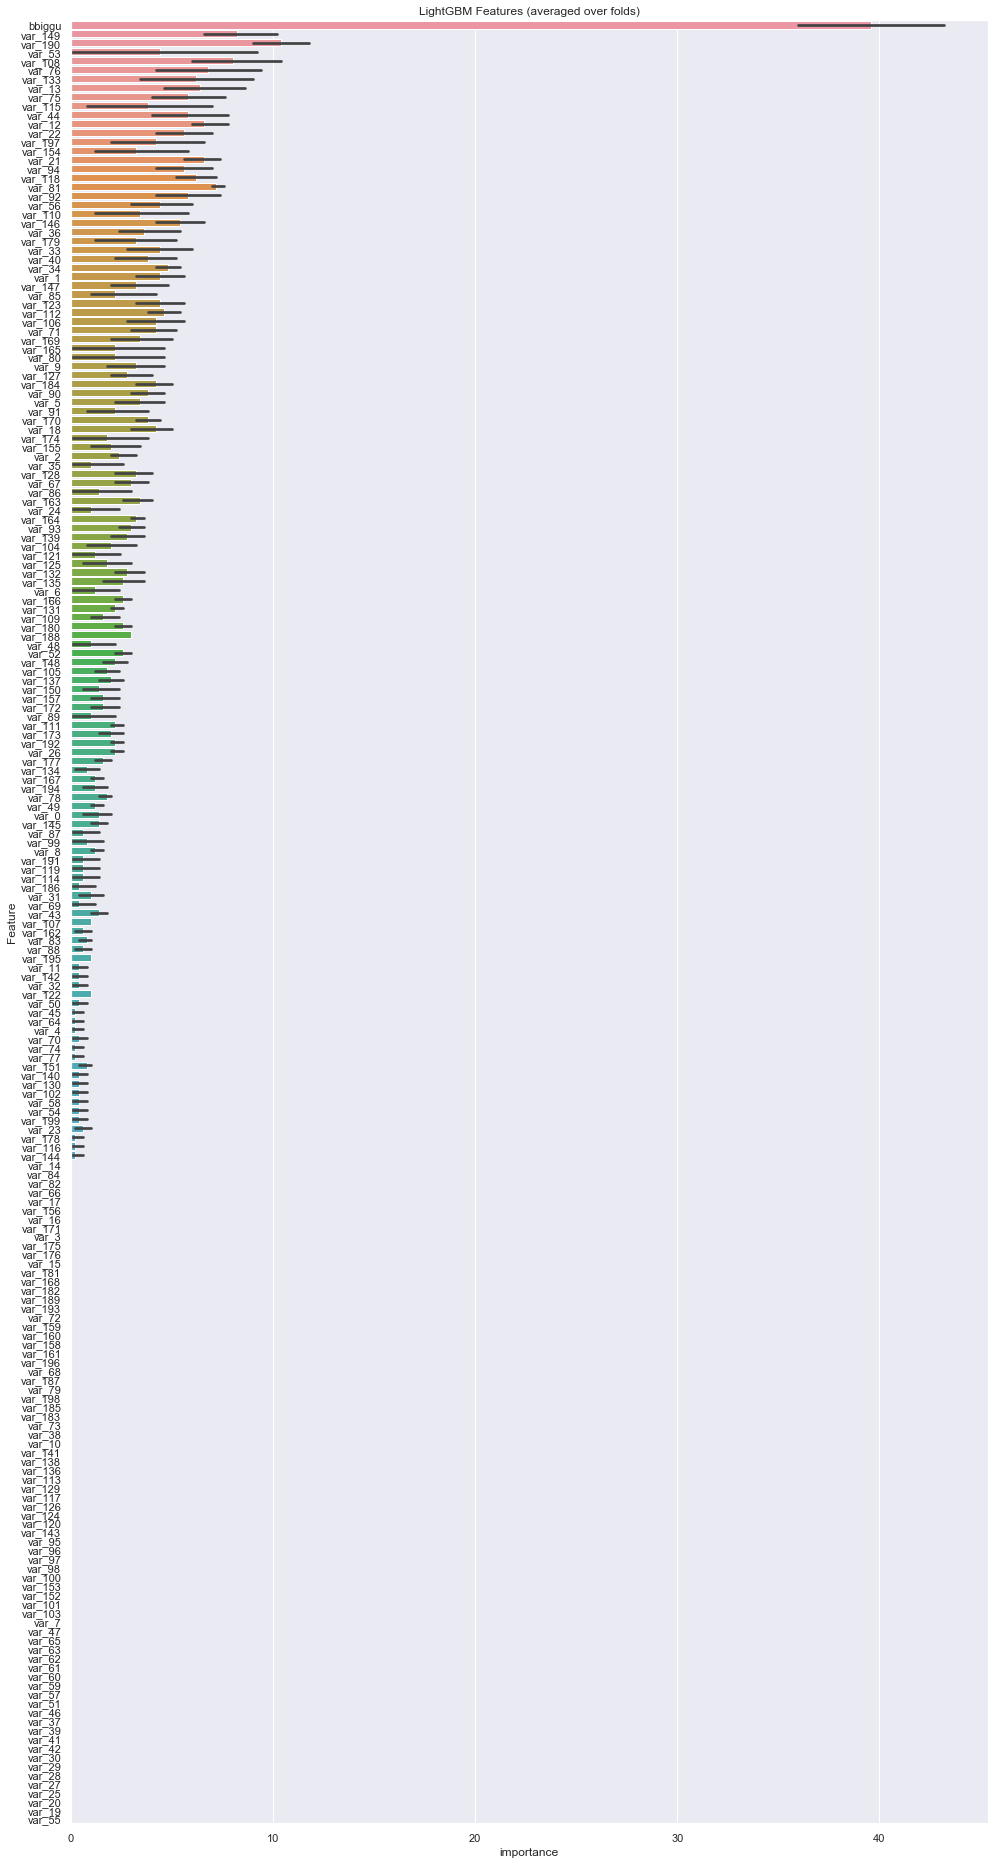

In [39]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

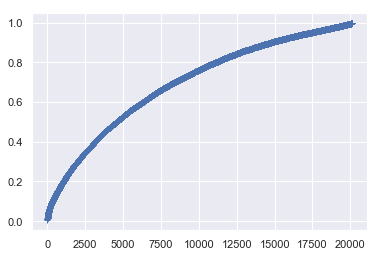

In [13]:
plt.plot(list(range(len(meta[meta.real == 1]))), meta[meta.real == 1].sort_values('pred').pred, '+')

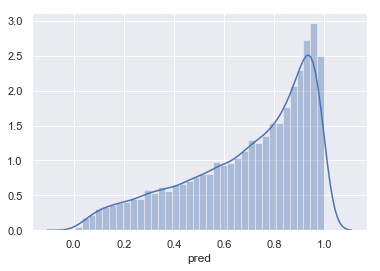

In [14]:
sns.distplot(meta[meta.real == 1].sort_values('pred').pred)

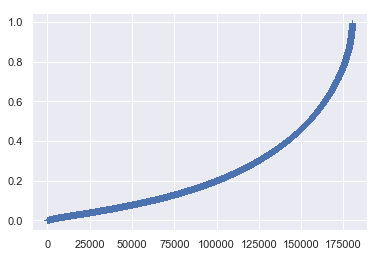

In [15]:
plt.plot(list(range(len(meta[meta.real == 0]))), meta[meta.real == 0].sort_values('pred').pred, '+')

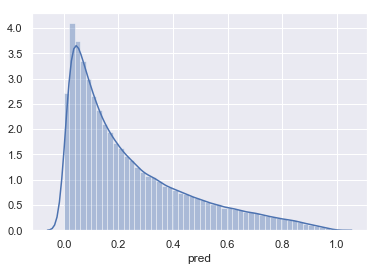

In [16]:
sns.distplot(meta[meta.real == 0].sort_values('pred').pred)

## 삐꾸찾기

In [17]:
meta = train.ID_code.to_frame()

In [18]:
meta['pred'] = oof_lgb
meta['real'] = target.values

In [19]:
meta['new_target'] = 0

In [21]:
meta.loc[(meta.pred > 0.5) & (meta.real == 0), 'new_target'] = 1
meta.loc[(meta.pred < 0.5) & (meta.real == 1), 'new_target'] = 1

In [46]:
meta

,ID_code,pred,real,new_target
0,train_0,0.070125,0,0
1,train_1,0.789087,0,1
2,train_2,0.062116,0,0
3,train_3,0.740973,0,1
4,train_4,0.351309,0,0
5,train_5,0.137047,0,0
6,train_6,0.493256,0,0
7,train_7,0.301840,0,0
8,train_8,0.416688,0,0
9,train_9,0.067308,0,0


## 삐꾸 분류기

In [25]:
bbiggu = meta.merge(train, on='ID_code', how='left')

In [27]:
bbiggu.head(3)

,ID_code,pred,real,new_target,target,var_0,var_1,var_2,var_3,var_4,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0.070125,0,0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0.789087,0,1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0.062116,0,0,0,8.6093,-2.7457,12.0805,7.8928,10.5825,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [28]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb2 = np.zeros(len(bbiggu))

train_columns = [c for c in train.columns if c not in ['ID_code', 'real', 'new_target', 'target']]
# train_coumns = new_feature

for fold_, (trn_idx, val_idx) in enumerate(folds.split(bbiggu, bbiggu.new_target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(bbiggu.iloc[trn_idx][train_columns], label=bbiggu.new_target.iloc[trn_idx])
    val_data = lgb.Dataset(bbiggu.iloc[val_idx][train_columns], label=bbiggu.new_target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb2[val_idx] = clf.predict(bbiggu.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(bbiggu.new_target.values[val_idx], oof_lgb2[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(bbiggu.new_target.values, oof_lgb2)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883933	valid_1's auc: 0.8649
[2000]	training's auc: 0.897725	valid_1's auc: 0.875582
[3000]	training's auc: 0.905642	valid_1's auc: 0.881319
[4000]	training's auc: 0.910568	valid_1's auc: 0.884013
[5000]	training's auc: 0.914309	valid_1's auc: 0.885293
[6000]	training's auc: 0.917796	valid_1's auc: 0.885789
Early stopping, best iteration is:
[6714]	training's auc: 0.92024	valid_1's auc: 0.885931
CV score: 0.88593 
fold n°1
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.882953	valid_1's auc: 0.869714
[2000]	training's auc: 0.896667	valid_1's auc: 0.880558
[3000]	training's auc: 0.904667	valid_1's auc: 0.885877
[4000]	training's auc: 0.909655	valid_1's auc: 0.888582
[5000]	training's auc: 0.913467	valid_1's auc: 0.889795
[6000]	training's auc: 0.917107	valid_1's auc: 0.890123
Early stopping, best iteration is:
[6350]	training's auc: 0.918308	valid_1's 

In [31]:
train['bbiggu'] = oof_lgb2

In [32]:
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,bbiggu
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,0.076818
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,0.868991
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,0.079362
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,0.851567
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,0.431094
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602,0.242621
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097,0.607761
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806,0.411076
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453,0.506797
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514,0.080674


In [219]:
bbiggu = meta.iloc[meta[meta.pred >= 0.8].index.tolist() + meta[meta.pred <= 0.2].index.tolist()]

In [220]:
bbiggu['new_target'] = 0

In [221]:
bbiggu.loc[(bbiggu.pred >= 0.8) & (bbiggu.real == 0), 'new_target'] = 1
bbiggu.loc[(bbiggu.pred <= 0.2) & (bbiggu.real == 1), 'new_target'] = 1

In [225]:
bbiggu_list = bbiggu[bbiggu.new_target == 1].index

In [227]:
train['bbiggu'] = 0

In [228]:
train.loc[train.index.isin(bbiggu_list), 'bbiggu'] = 1

In [230]:
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,bbiggu
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,0
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,0
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,0
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,0
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,0
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602,0
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097,0
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806,0
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453,0
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514,0


In [166]:
bbiggu = bbiggu.merge(train, how='left', on='ID_code')

In [193]:
len(bbiggu)

113626

In [175]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb2 = np.zeros(len(bbiggu))

train_columns = [c for c in train.columns if c not in ['ID_code', 'pred', 'real', 'new_target', 'target']]
# train_coumns = new_feature

for fold_, (trn_idx, val_idx) in enumerate(folds.split(bbiggu, bbiggu.new_target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(bbiggu.iloc[trn_idx][train_columns], label=bbiggu.new_target.iloc[trn_idx])
    val_data = lgb.Dataset(bbiggu.iloc[val_idx][train_columns], label=bbiggu.new_target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb2[val_idx] = clf.predict(bbiggu.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(bbiggu.new_target.values[val_idx], oof_lgb2[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(bbiggu.new_target.values, oof_lgb2)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.928046	valid_1's auc: 0.880021
Early stopping, best iteration is:
[1514]	training's auc: 0.941352	valid_1's auc: 0.881385
CV score: 0.88138 
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[571]	training's auc: 0.915693	valid_1's auc: 0.876844
CV score: 0.87684 
fold n°2
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.927841	valid_1's auc: 0.88191
Early stopping, best iteration is:
[1180]	training's auc: 0.932772	valid_1's auc: 0.882386
CV score: 0.88239 
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's auc: 0.904249	valid_1's auc: 0.879711
CV score: 0.87971 
fold n°4
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.928398	valid_1's auc: 0.874604
[2000]	training's auc: 0.949301	val

In [196]:
meta

,ID_code,pred,real
0,train_0,0.070125,0
1,train_1,0.789087,0
2,train_2,0.062116,0
3,train_3,0.740973,0
4,train_4,0.351309,0
5,train_5,0.137047,0
6,train_6,0.493256,0
7,train_7,0.301840,0
8,train_8,0.416688,0
9,train_9,0.067308,0


In [236]:
# bbiggu = bbiggu.drop(train_columns, axis = 1)
bbiggu['bbiggu_prob'] = oof_lgb2

In [243]:
train = train.drop(['bbiggu'], axis = 1).merge(bbiggu[['ID_code', 'bbiggu_prob']], on='ID_code', how='left').fillna(0)

In [237]:
bbiggu

,ID_code,pred,real,new_target,bbiggu_prob
13,train_13,0.817193,1,0,0.806716
63,train_63,0.951546,1,0,0.698380
65,train_65,0.972371,1,0,0.875158
76,train_76,0.843698,0,1,0.684953
90,train_90,0.852117,0,1,0.522354
130,train_130,0.865162,1,0,0.850919
193,train_193,0.886228,0,1,0.584563
223,train_223,0.949184,1,0,0.882390
234,train_234,0.930101,1,0,0.882102
239,train_239,0.976744,1,0,0.908856


In [190]:
pd.set_option('max_row', 100)

In [208]:
temp1 = meta[meta.real == 1][(meta[meta.real == 1].pred >= 0.4) & (meta[meta.real == 1].pred <= 0.6)].index
meta.loc[meta.index.isin(temp1), 'pred'] = 0.6

In [210]:
roc_auc_score(target.values, meta.pred)

0.9065768629315072

In [211]:
temp2 = meta[meta.real == 0][(meta[meta.real == 0].pred >= 0.4) & (meta[meta.real == 0].pred <= 0.6)].index
meta.loc[meta.index.isin(temp2), 'pred'] = 0.4

In [212]:
roc_auc_score(target.values, meta.pred)

0.9065768629315072

In [74]:
temp1 = meta[meta.real == 0][meta[meta.real == 0].pred > 0.8].index
meta.loc[meta.index.isin(temp1), 'pred'] = 0.1

In [75]:
roc_auc_score(target.values, meta.pred)

0.9142074456390799

In [76]:
temp2 = meta[meta.real == 1][meta[meta.real == 1].pred < 0.2].index
meta.loc[meta.index.isin(temp2), 'pred'] = 0.9

In [77]:
roc_auc_score(target.values, meta.pred)

0.9453664373781043

In [117]:
train['new_target'] = 0

In [119]:
train.loc[train.index.isin(temp1), 'new_target'] = 1